In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import glob

In [2]:
cernbox = '/Users/emiliebertholet/cernbox/coldbox_data/LED/Vitaliy'

ch = 10
channels = [ch]
data = {}
# ## LED 6.2 
for ch in channels:
    files = glob.glob(f'{cernbox}/adc_data_run_24100_srcid_*_ch_{ch}_*.npy')
    concatData  = [np.load(file, allow_pickle=True).astype(np.int16) for file in files]
    d = np.concatenate(concatData, axis=0)
    data[ch] = d
    print(f'ch{ch}:', d.shape)
data = data[ch]


ch10: (7481, 50000)


In [3]:
# LED_freq = 20e3
# DAQ_tt   = 50000 # 800 us
# tt_to_us = 800 / 50000 # 0.016us = 16ns
# nLED_pulses_per_trigger = int(DAQ_tt*tt_to_us/(1e6/LED_freq)) # 16
# pulse_window = data.shape[1] // nLED_pulses_per_trigger # 3125

In [4]:
def align_waforms(data, time_shift, ADCsat):
    # ADCsat = ADCsat = data.max().max()
    # print(f'ADCsat for ch{ch}  = {ADCsat}')
    nLED_pulses_per_trigger=3125
    data_split = []
    for i in range(0,len(data)):
        wf = data[i]
        for j in range(0, 15):
            sub_wf = wf[time_shift+j*nLED_pulses_per_trigger:time_shift+(j+1)*nLED_pulses_per_trigger][1900:2100-25]
            if sub_wf.max()<ADCsat:
                data_split.append(sub_wf)
    return np.array(data_split)

def substract_pedestals(array_2d):
    subtracted, pedestals = [], []
    for row in array_2d:
        pedestal = np.argmax(np.bincount(row))
        subtracted.append(row - pedestal)
        pedestals.append(pedestal)
    return np.array(subtracted), np.array(pedestals)

ADCsat for ch10  = 16383


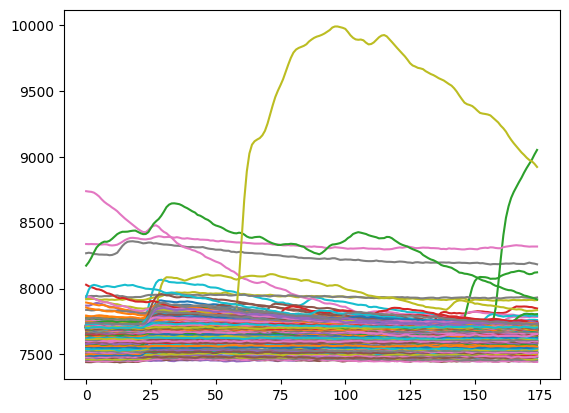

In [5]:
ADCsat = ADCsat = data.max().max()
print(f'ADCsat for ch{ch}  = {ADCsat}')

pulses = align_waforms(data, time_shift=600, ADCsat = ADCsat)
for i in range(1000):  # first 1000 pulses
    plt.plot(pulses[i])

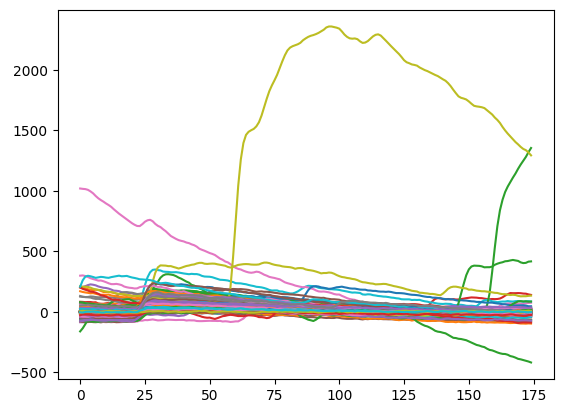

In [6]:
pulses_bs, _ = substract_pedestals(pulses)

for i in range(1000):  # first 1000 pulses
    plt.plot(pulses_bs[i])

## Improve selection

In [7]:
peak_height = np.max(pulses_bs, axis=1)
abs_pulses  = np.abs(pulses_bs)
rightMax = np.max( abs_pulses[:, 120:], axis=1)
leftMax = np.max( abs_pulses[:, :15], axis=1)


(107494, 175)


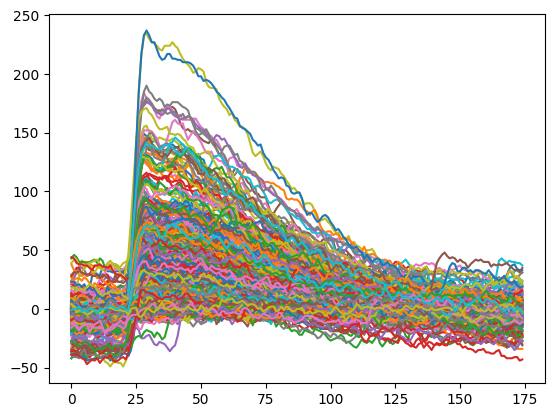

In [8]:
# mask = (peak_height < 350) & (rightMax < 10) & (leftMax < 10) 
mask = (peak_height < 50000) & (rightMax < 50) & (leftMax < 50) 
# mask = (peak_height < 350) & (rightMax < 30) & (leftMax < 30) 
pulses_sel = pulses_bs[mask]
print(pulses_sel.shape)
for i in range(1000):  # first 1000 pulses
    plt.plot(pulses_sel[i])
# plt.ylim(-20, 350)

## Find Integration window

30


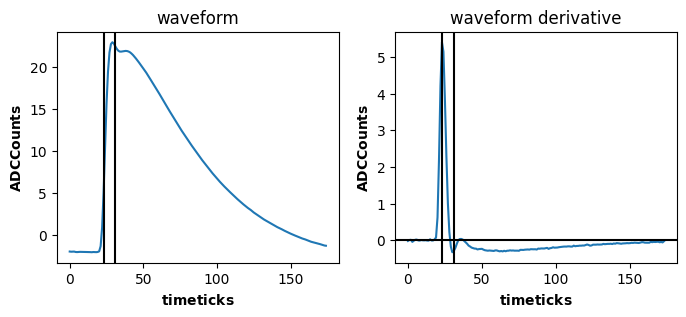

In [9]:
## find integration window (Vitaliy's method)
# 1. Get derivative of avg. waveform
# 2. Selecting the interval between the spike (rising edge) and “getting back to 0” for the waveform derivative

# pulses_sel = pulses_bs

avg_wf      = pulses_sel.mean(axis=0)
avg_wf_diff = np.diff(avg_wf)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
ax = axs[0]
ax.plot(np.arange(0, len(avg_wf), 1), avg_wf);
ax.set_xlabel(r"$\mathrm{\bf time ticks}$");
ax.set_ylabel(r"$\mathrm{\bf ADC Counts}$");
ax.set_title(r"waveform");
# ax.set_xlim(0, 400)

rising_edge_idx = np.argmax(avg_wf_diff)
bound_min = np.argmax(avg_wf_diff) # rising edge
min_idx = np.argmin(avg_wf_diff)
epsilon = 0.4
for i in range(min_idx, len(avg_wf_diff)):
    if abs(avg_wf_diff[i]) < epsilon:
        print(i)
        bound_max = i + 1
        break

ax.axvline(x=bound_min, color='black')
ax.axvline(x=bound_max, color='black')
ax = axs[1]
ax.plot(np.arange(0, len(avg_wf_diff), 1), avg_wf_diff);
ax.axhline(y=0, color='black')
ax.set_xlabel(r"$\mathrm{\bf time ticks}$");
ax.set_ylabel(r"$\mathrm{\bf ADC Counts}$");
ax.set_title(r"waveform derivative");
ax.axvline(x=bound_min, color='black')
ax.axvline(x=bound_max, color='black');


## Plot Charge

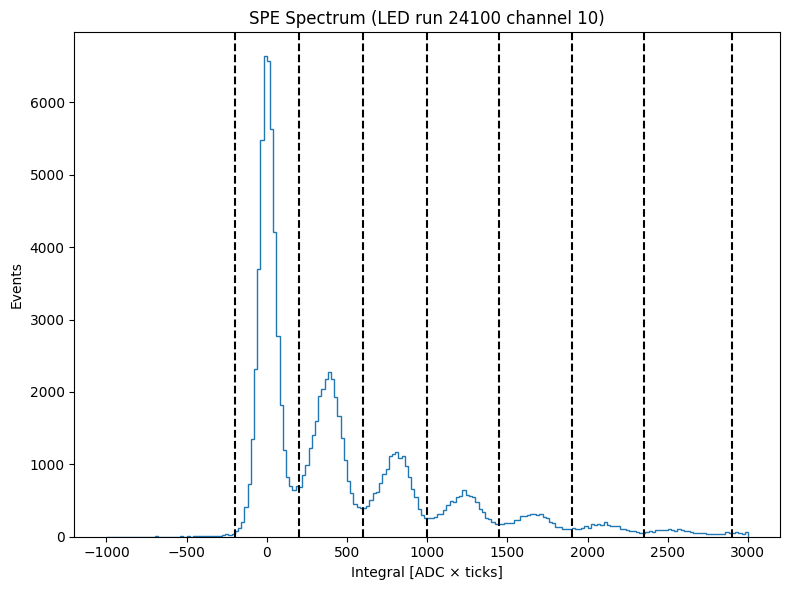

In [45]:
bound_max = 50
integrals = np.sum(pulses_sel[:, bound_min:bound_max], axis=1)


SPE_min = 200

plt.figure(figsize=(8, 6))
rg =(-1000, 3000)
plt.hist( integrals, bins=200, range=rg, histtype='step')
plt.axvline(x=-200, color='black',  linestyle='--')
plt.axvline(x=200, color='black',  linestyle='--')
plt.axvline(x=600, color='black',  linestyle='--')
plt.axvline(x=1000, color='black',  linestyle='--')
plt.axvline(x=1450, color='black',  linestyle='--')
plt.axvline(x=1900, color='black',  linestyle='--')
plt.axvline(x=2350, color='black',  linestyle='--')
plt.axvline(x=2900, color='black',  linestyle='--')
plt.xlabel("Integral [ADC × ticks]")
plt.ylabel("Events")
plt.title("SPE Spectrum (LED run 24100 channel 10)")
plt.tight_layout()
plt.show()

### TODO
- fit peaks
- compute distance between them
- select SPE within $2 \sigma$ etc.

# Average 1 SPE

In [22]:
def select_pulses_per_SPEnumber(pulses, lower_threshold, upper_threshold):
    mask = (integrals >= lower_threshold) & (integrals <= upper_threshold)
    selected_pulses = pulses_sel[mask]
    print(f'{len(selected_pulses)} pulses with integral between {lower_threshold} and {upper_threshold}')
    pulse_avg = selected_pulses.mean(axis=0)
    return selected_pulses, pulse_avg

46145 pulses with integral between -200 and 200
26047 pulses with integral between 200 and 600
14698 pulses with integral between 600 and 1000
8826 pulses with integral between 1000 and 1450
4927 pulses with integral between 1450 and 1900
2815 pulses with integral between 1900 and 2350
1840 pulses with integral between 2350 and 2900


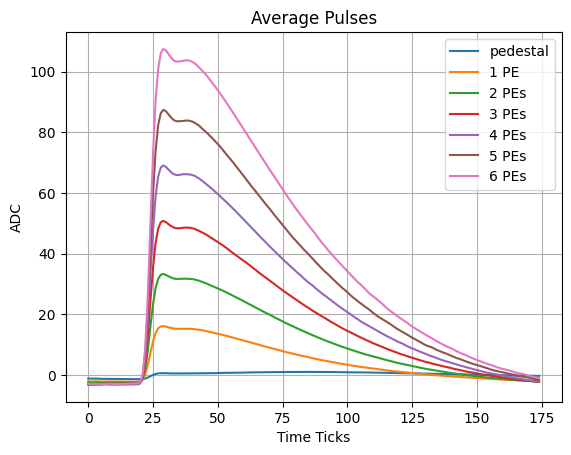

In [47]:

_, pulse_avg_ped = select_pulses_per_SPEnumber(pulses_sel, -200, 200)
_, pulse_avg_1SPE = select_pulses_per_SPEnumber(pulses_sel, 200, 600)
_, pulse_avg_2SPE = select_pulses_per_SPEnumber(pulses_sel, 600, 1000)
_, pulse_avg_3SPE = select_pulses_per_SPEnumber(pulses_sel, 1000, 1450)
_, pulse_avg_4SPE = select_pulses_per_SPEnumber(pulses_sel, 1450, 1900)
_, pulse_avg_5SPE = select_pulses_per_SPEnumber(pulses_sel, 1900, 2350)
_, pulse_avg_6SPE = select_pulses_per_SPEnumber(pulses_sel, 2350, 2900)


plt.plot(pulse_avg_ped, label = f'pedestal')
plt.plot(pulse_avg_1SPE, label = f'1 PE')
plt.plot(pulse_avg_2SPE, label = f'2 PEs')
plt.plot(pulse_avg_3SPE, label = f'3 PEs')
plt.plot(pulse_avg_4SPE, label = f'4 PEs')
plt.plot(pulse_avg_5SPE, label = f'5 PEs')
plt.plot(pulse_avg_6SPE, label = f'6 PEs')

plt.xlabel("Time Ticks")
plt.ylabel("ADC")
plt.title(f"Average Pulses")
plt.grid(True)
plt.legend()
plt.show()

5234 pulses with integral between 200 and 300


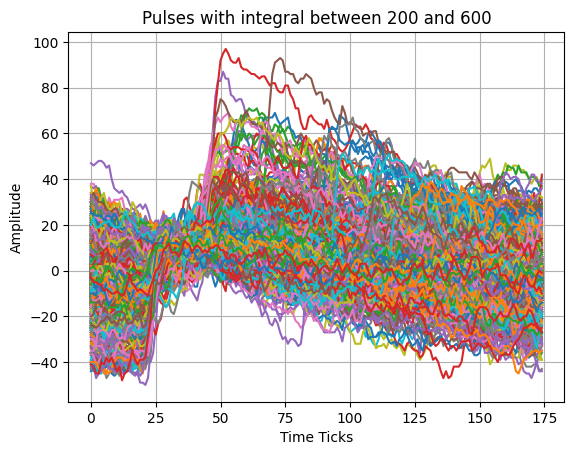

In [25]:
lower_threshold = 200
upper_threshold = 600


pulses_1SPE, pulse_avg_1SPE = select_pulses_per_SPEnumber(pulses_sel, 200, 300)

for pulse in pulses_1SPE:
    plt.plot(pulse)


plt.xlabel("Time Ticks")
plt.ylabel("Amplitude")
plt.title(f"Pulses with integral between {lower_threshold} and {upper_threshold}")
plt.grid(True)
plt.show()

